# MyoPS 2020 Challenge

Ideas: 
 - load data via torchio
 - include meaningful augmentations
 - retrain base network (U-Net, resnet34)
 - use fastai2
 - use all labels (incl. LV, MY, RV)
 - use cross validation on training set to estimate performance

In [1]:
!pip install fastai2

In [0]:
from fastai2.vision.all import *
from fastai2.vision.models import resnet34

### fastai U-Net on these static images

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = "/content/drive/My Drive/miccai2020/myops/png"

In [0]:
myopsData = DataBlock(blocks=(ImageBlock, MaskBlock(codes = ['bg','lv','my','rv','ed','sc'])),
    get_items=get_image_files,
    splitter=FuncSplitter(lambda o: int(o.name.split("-")[0]) < 106),
    get_y=lambda o: str(o).replace("images","masks"),
    item_tfms=Resize(256),
    batch_tfms=aug_transforms(max_rotate=90))
myopsDls = myopsData.dataloaders(f'{path}/images',num_workers=8,batch_size=4)

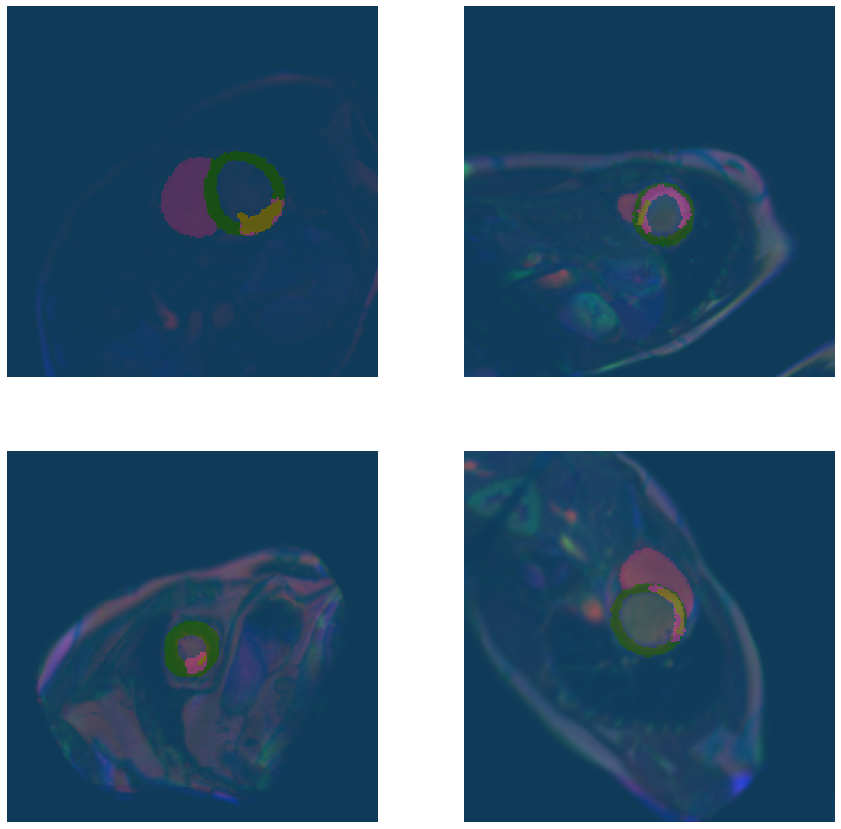

In [6]:
myopsDls.show_batch(figsize=(15,15))

In [0]:
def multi_dice(input:Tensor, targs:Tensor, class_id=0, inverse=False)->Tensor:
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    # replace all with class_id with 1 all else with 0 to have binary case
    output = (input == class_id).float()
    # same for targs
    targs = (targs.view(n,-1) == class_id).float()
    if inverse:
        output = 1 - output
        targs = 1 - targs
    intersect = (output * targs).sum(dim=1).float()
    union = (output+targs).sum(dim=1).float()
    res = 2. * intersect / union
    res[torch.isnan(res)] = 1
    return res.mean()

#dice0inv = partial(multi_dice, class_id=0, inverse=True)
#dice1 = partial(multi_dice, class_id=1)
#dice2 = partial(multi_dice, class_id=2)
#dice3 = partial(multi_dice, class_id=3)
#dice4 = partial(multi_dice, class_id=4)
#dice5 = partial(multi_dice, class_id=5)
def diceLV(input, targs): return multi_dice(input,targs,class_id=1)
def diceMY(input, targs): return multi_dice(input,targs,class_id=2)
def diceRV(input, targs): return multi_dice(input,targs,class_id=3)
def diceEd(input, targs): return multi_dice(input,targs,class_id=4)
def diceSc(input, targs): return multi_dice(input,targs,class_id=5)
dices = [diceLV,diceMY,diceRV,diceEd,diceSc]

In [0]:
learn = unet_learner(myopsDls, resnet34, metrics=[foreground_acc, *dices])

SuggestedLRs(lr_min=0.00043651582673192023, lr_steep=3.630780702224001e-05)

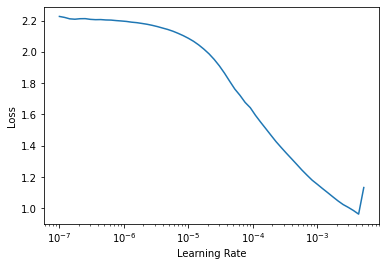

In [9]:
learn.lr_find()

In [10]:
learn.fit_one_cycle(10,lr_max=1e-3)

epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.103495,0.058437,0.609285,0.742462,0.495615,0.629719,0.078860,0.250000,00:42
1,0.055185,0.044584,0.761527,0.831948,0.633433,0.754557,0.079227,0.178918,00:36
2,0.045155,0.045719,0.705365,0.824422,0.648351,0.707816,0.100000,0.279342,00:36
3,0.039759,0.050042,0.695148,0.837526,0.624320,0.716795,0.095431,0.262468,00:36
4,0.036202,0.037944,0.740604,0.848843,0.673653,0.748180,0.101102,0.302715,00:36
5,0.031492,0.035841,0.777738,0.836073,0.680694,0.808372,0.100942,0.272544,00:36
6,0.028470,0.037170,0.737876,0.847798,0.651146,0.762588,0.123704,0.300881,00:36
7,0.027553,0.035461,0.744745,0.865387,0.673981,0.763752,0.108608,0.334656,00:36
8,0.026925,0.033378,0.769893,0.869479,0.663746,0.804165,0.123939,0.331692,00:36
9,0.024653,0.033518,0.758703,0.870014,0.665642,0.790792,0.120659,0.351551,00:36


SuggestedLRs(lr_min=6.918309954926372e-05, lr_steep=7.585775847473997e-07)

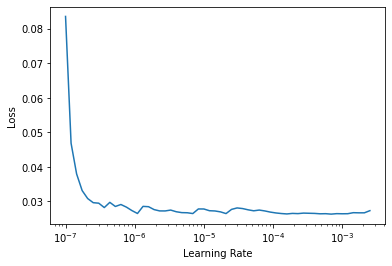

In [11]:
learn.unfreeze()
learn.lr_find()

In [12]:
learn.fit_one_cycle(10,lr_max=1e-4)

epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.025281,0.035136,0.751462,0.862872,0.655472,0.788882,0.110403,0.339748,00:39
1,0.025065,0.034824,0.757383,0.861334,0.648501,0.800227,0.138086,0.335113,00:39
2,0.025445,0.035313,0.748608,0.868901,0.667247,0.786412,0.117341,0.339302,00:39
3,0.024196,0.035594,0.753832,0.863459,0.662804,0.798773,0.115273,0.362152,00:39
4,0.026630,0.036320,0.770569,0.858719,0.678521,0.805337,0.118388,0.316832,00:39
5,0.022941,0.035467,0.759035,0.865640,0.675406,0.788458,0.135434,0.351636,00:39
6,0.022372,0.037848,0.745376,0.873410,0.681774,0.775755,0.127727,0.351010,00:39
7,0.021952,0.036592,0.757228,0.871535,0.684904,0.785804,0.121855,0.364743,00:39
8,0.021233,0.037844,0.753034,0.872401,0.681519,0.784385,0.115393,0.339435,00:39
9,0.020633,0.037363,0.755020,0.873379,0.679079,0.786161,0.113226,0.361696,00:39


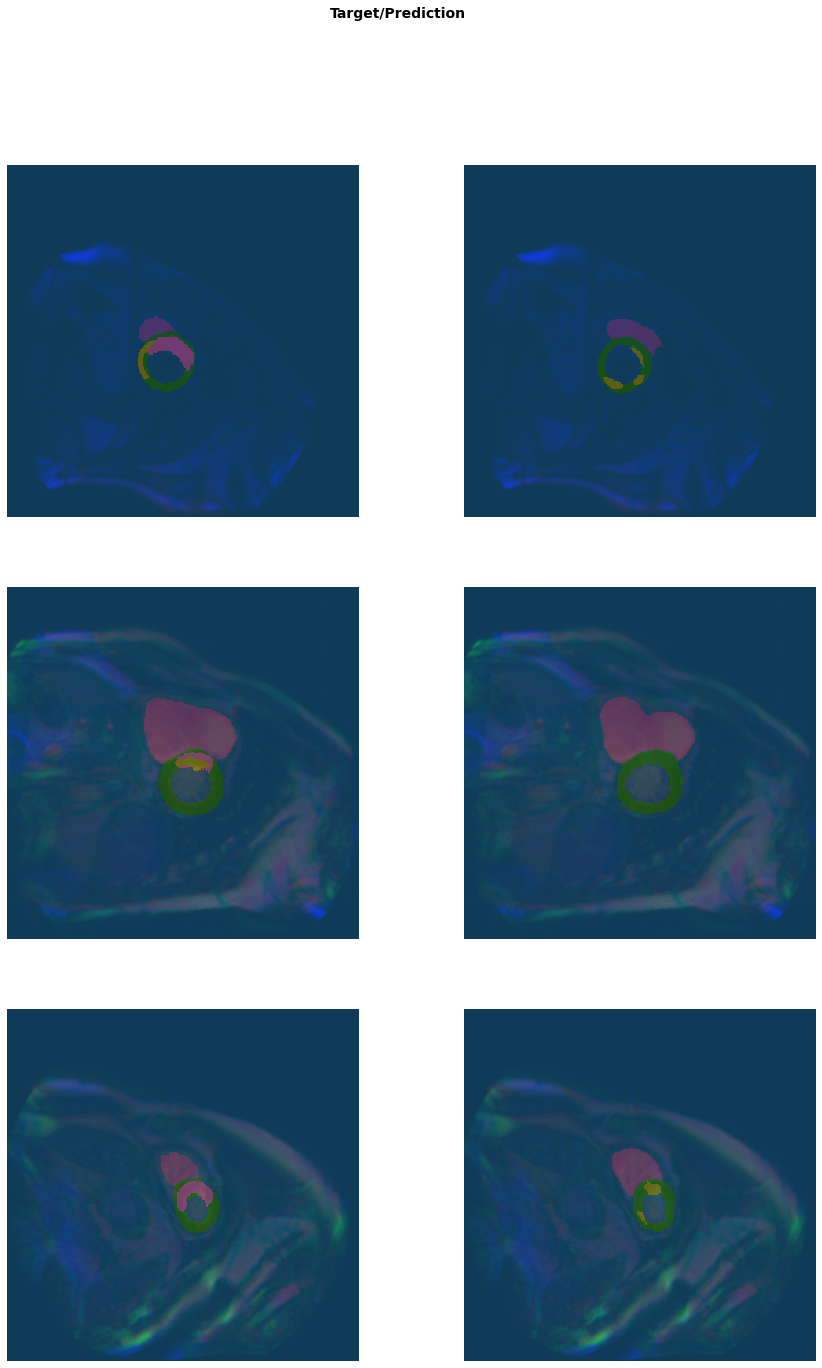

In [13]:
learn.show_results(figsize=(15,22))

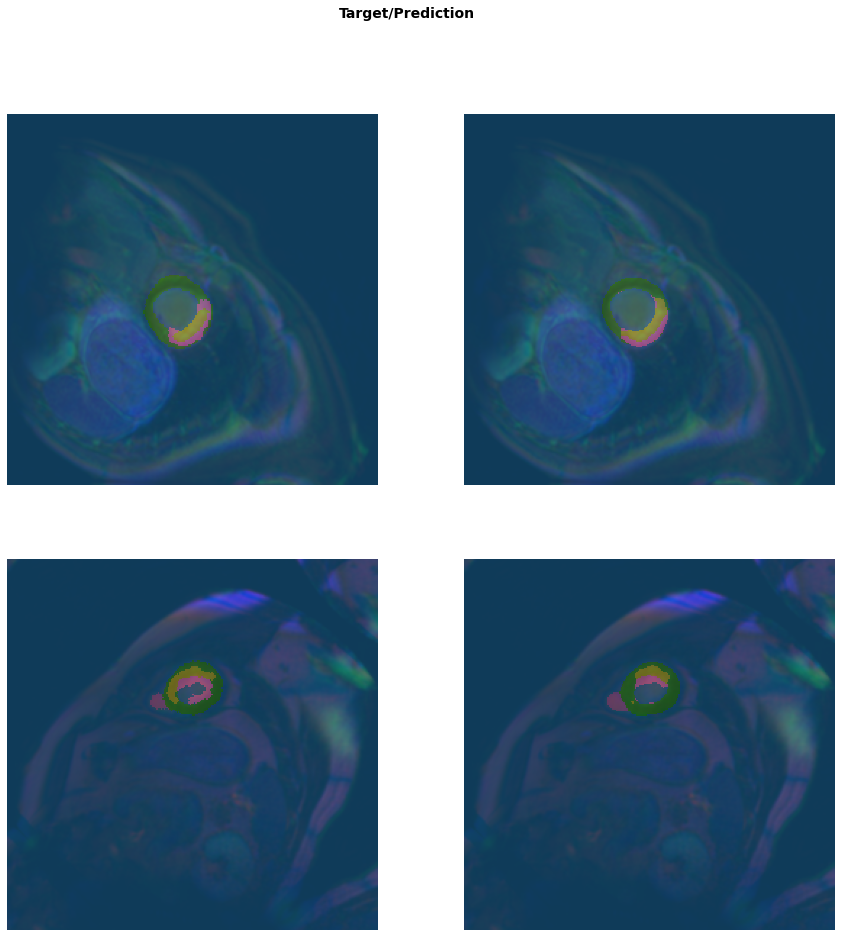

In [14]:
learn.show_results(ds_idx=0, figsize=(15,15))